Visualisation of optimisation algorithms
========================================

Written as part of an invited talk at the Aspects of Neuroscience BrainHack 2017, Warsaw, Poland.

Sebiastian Ruder has written [an excellent paper](#cite_ruder_paper) and [blog post](#cite_ruder_blog) about many different optimisation algorithms, but I couldn't find any associated code, while wanting to try the algorithms on other cost functions, tweak the parameters and observe first-hand how the different methods compare; hence this notebook.

By Charl Linssen &lt;<a href="mailto:charl@itfromb.it">charl@itfromb.it</a>&gt;, Nov 19th, 2017.

Released under the CC0 1.0 Universal ("public domain") licence.

N.B. the indexing convention: function arguments are passed as (x, y), where x is the horizontal and y the vertical coordinate, but matrix indexing (for ``X``, ``Y``, ``Z`` and ``Z_grad``) is [yi, xi].

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import scipy.ndimage
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

HTML('<style> .text_cell_render li { margin-bottom: 1em !important } </style>')

In [2]:
def plot_cost_func(X, Y, Z, arr=None, Z_grad=None, title=None):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(1, 2, 1)

    ax1.contour(X, Y, Z, colors='black')
    ax1.imshow(Z, interpolation='bilinear', origin='lower',
                cmap=mpl.cm.coolwarm, extent=(np.amin(X), np.amax(X), np.amin(Y), np.amax(Y)))
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")

    if Z_grad is not None:
        stride = int(np.mean(X.shape)) // 10
        ax1.quiver(X[::stride, ::stride], Y[::stride, ::stride],
                    Z_grad[::stride, ::stride, 0], Z_grad[::stride, ::stride, 1],
                    pivot="mid")
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax2.plot_surface(X, Y, Z, cmap=mpl.cm.coolwarm, linewidth=0, antialiased=False)
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")

    if arr is not None:
        arr = np.array(arr)
        for i in range(len(arr) - 1):
            ax1.plot(arr[i:i+2, 0], arr[i:i+2, 1], color="orange", linestyle="-")
            ax1.scatter(arr[i:i+2, 0], arr[i:i+2, 1], edgecolors="orange", marker="o", facecolors="none")
            ax2.plot(arr[i:i+2, 0], arr[i:i+2, 1], arr[i:i+2, 2], color="orange")

        #for i in range(len(arr) - 1):
            #ax2.scatter(arr[i, 0], arr[i, 1], arr[i,2], marker="o", color="orange")
            #print(arr.shape)
    
    if not title is None:
        fig.suptitle(title)

First, define the cost function. The function is defined over a regularly spaced grid in two dimensions. When defining your own cost function, try to normalise to a Z-range of roughly [-1..+1] to keep the gradients in the same range.

- $f(x,y)=\frac{1}{50} x^2 + y^2$

  Simple quadratic with one global minimum. Note that the gradient along the first dimension is much lower than the gradient along the second dimension.

- $f(x,y)=x^2 - y^2$
  
  Function with a saddle point at (0, 0).

- Noise function: generated by drawing samples from a normal(0, 1) distribution on a discrete grid and then filtering with a Gaussian kernel.

In [3]:
xmin, xmax = -1., 1.
ymin, ymax = -2., 2.
n_points_x = 21      # best to pick odd values for n_points to make sure (0, 0) is included
n_points_y = 41

ftype = "quad"
convergence_threshold = 1E-3
max_iter = 50

if ftype == "quad":
    initial_point = np.array([.5, 1.5])
elif ftype == "saddle":
    initial_point = np.array([.1, .1])
elif ftype == "noise":
    initial_point = np.array([0., 0.])


<IPython.core.display.Javascript object>


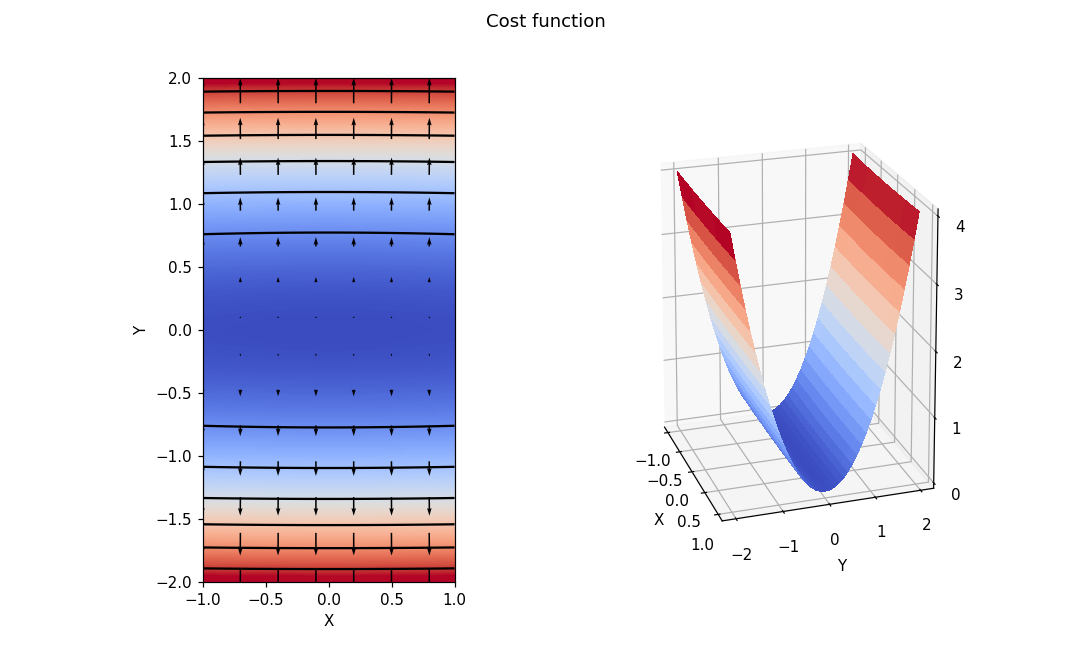

Cost function global minimum: 0.0


In [4]:
xi = np.linspace(xmin, xmax, n_points_x)
yi = np.linspace(ymin, ymax, n_points_y)
X, Y = np.meshgrid(xi, yi, indexing="xy")

assert ftype in ["saddle", "quad", "noise"]

if ftype == "noise":
    Z = sp.stats.norm(0., 1.).rvs(size=(len(yi), len(xi)))
    Z = 10. * sp.ndimage.filters.gaussian_filter(Z, sigma=16.)
    Z_grad = np.stack(np.gradient(Z.T)).transpose((2, 1, 0))

def f(x):
    """the cost function"""
    if ftype == "quad":
        return .02 * x[0]**2 + x[1]**2
    elif ftype == "saddle":
        return x[0]**2 - x[1]**2
    elif ftype == "noise":
        xidx = np.argmin((xi - x[0])**2)
        yidx = np.argmin((yi - x[1])**2)
        return Z[yidx, xidx]

def g(x):
    """the gradient of the cost function"""
    if not (np.all(xmin <= x[0, ...]) \
           and np.all(x[0, ...] <= xmax) \
           and np.all(ymin <= x[1, ...]) \
           and np.all(x[1, ...] <= ymax)):
        return np.array([0., 0.])
    if ftype == "quad":
        return np.array([.04 * x[0], 2. * x[1]])
    elif ftype == "saddle":
        return np.array([2 * x[0], -2 * x[1]])
    elif ftype == "noise":
        # no analytic gradient available; return the numerical gradient
        xidx = np.argmin((xi - x[0])**2)
        yidx = np.argmin((yi - x[1])**2)
        return Z_grad[yidx, xidx, :]

if not ftype == "noise":
    Z = f(np.stack([X, Y]))
    Z_grad = g(np.stack([X, Y])).transpose(1, 2, 0)

plot_cost_func(X, Y, Z, Z_grad=Z_grad, title="Cost function")
print("Cost function global minimum: " + str(np.amin(Z)))

Vanilla gradient descent
========================

<IPython.core.display.Javascript object>


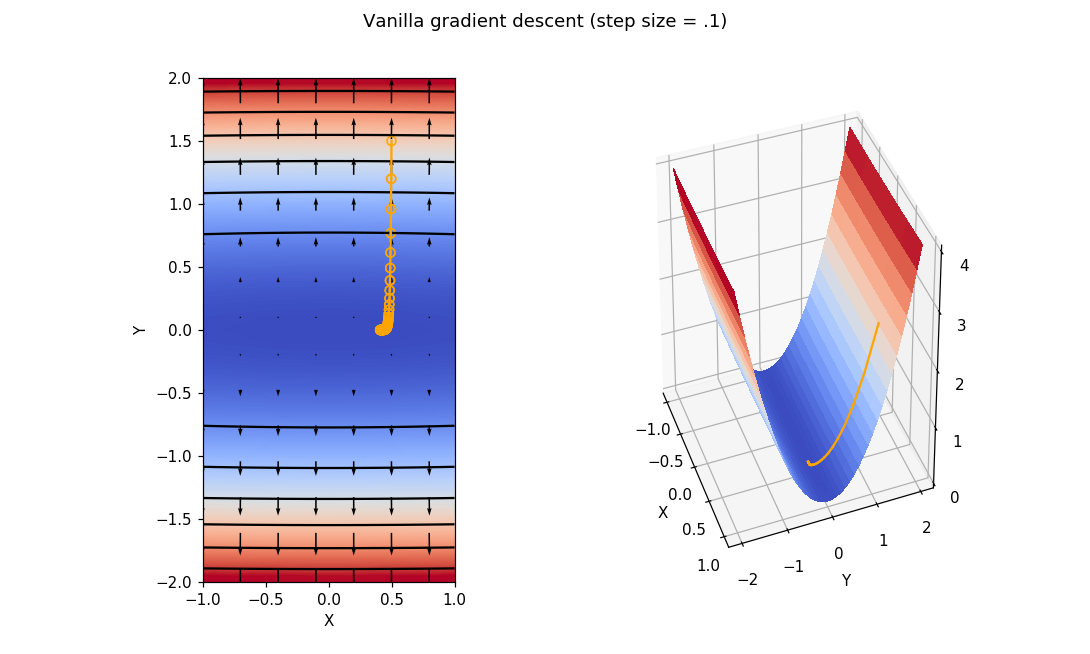

In [5]:
def gd(x_start, step, g, convergence_threshold=1E-6, max_iter=100, debug=False):
    """vanilla gradient descent"""
    x = np.array(x_start, dtype='float64')
    trajectory = [[x[0], x[1], f(x)]]
    for i in range(max_iter):
        grad = g(x)
        if debug:
            print('[ Epoch {0} ] x = {1}, grad = {2}, f = {3}'.format(i, x, grad, f(x)))
        x -= grad * step
        trajectory.append([x[0], x[1], f(x)])
        if abs(sum(grad)) < convergence_threshold:
            print("Converged in " + str(i+1) + " iterations, f = " + str(f(x)))
            break
    return x, trajectory

res, trajectory = gd(initial_point, .1, g, convergence_threshold=convergence_threshold, max_iter=max_iter)
plot_cost_func(X, Y, Z, trajectory, Z_grad=Z_grad, title="Vanilla gradient descent (step size = .1)")

<IPython.core.display.Javascript object>


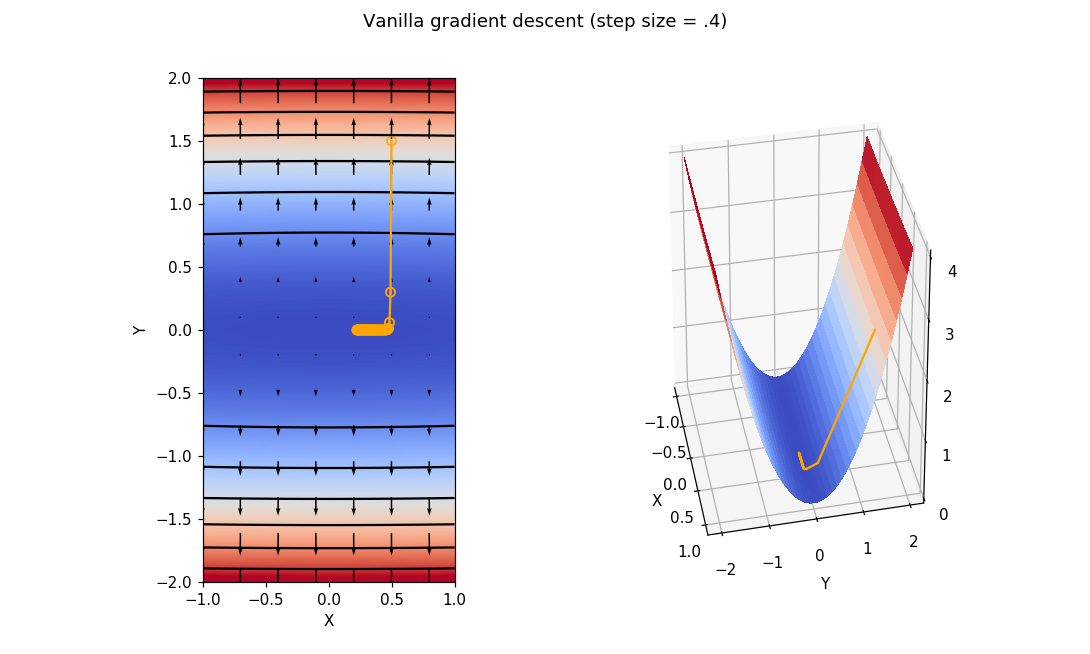

In [6]:
res, trajectory = gd(initial_point, .4, g, convergence_threshold=convergence_threshold, max_iter=max_iter)
plot_cost_func(X, Y, Z, trajectory, Z_grad=Z_grad, title="Vanilla gradient descent (step size = .4)")

<IPython.core.display.Javascript object>


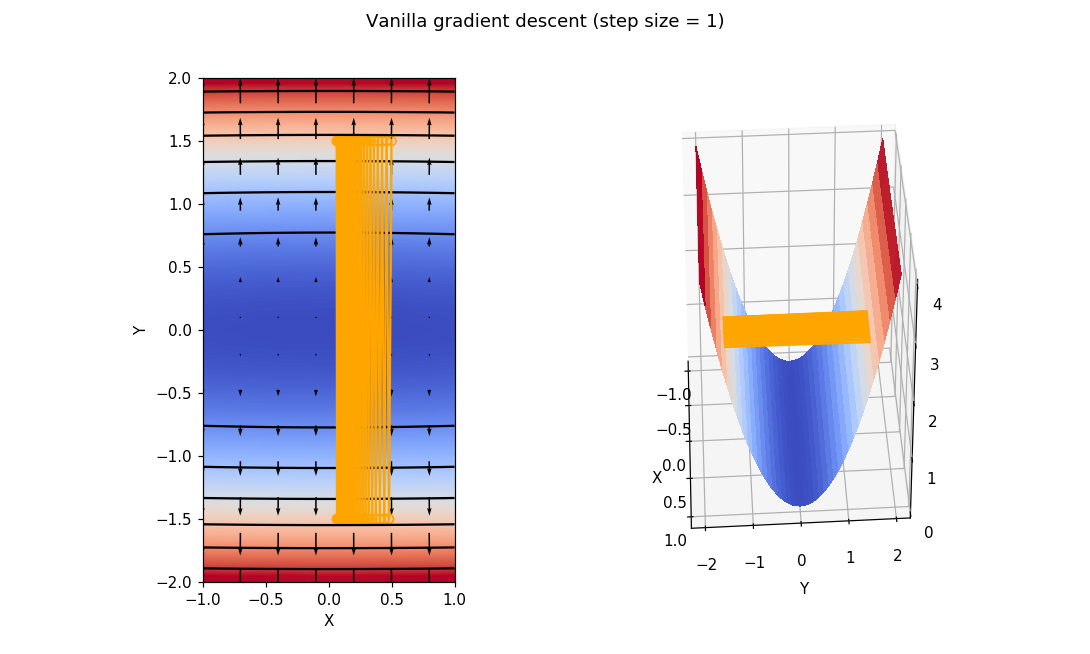

In [7]:
res, trajectory = gd(initial_point, 1., g, convergence_threshold=convergence_threshold, max_iter=max_iter)
plot_cost_func(X, Y, Z, trajectory, Z_grad=Z_grad, title="Vanilla gradient descent (step size = 1)")

Gradient descent with momentum
==============================

<IPython.core.display.Javascript object>


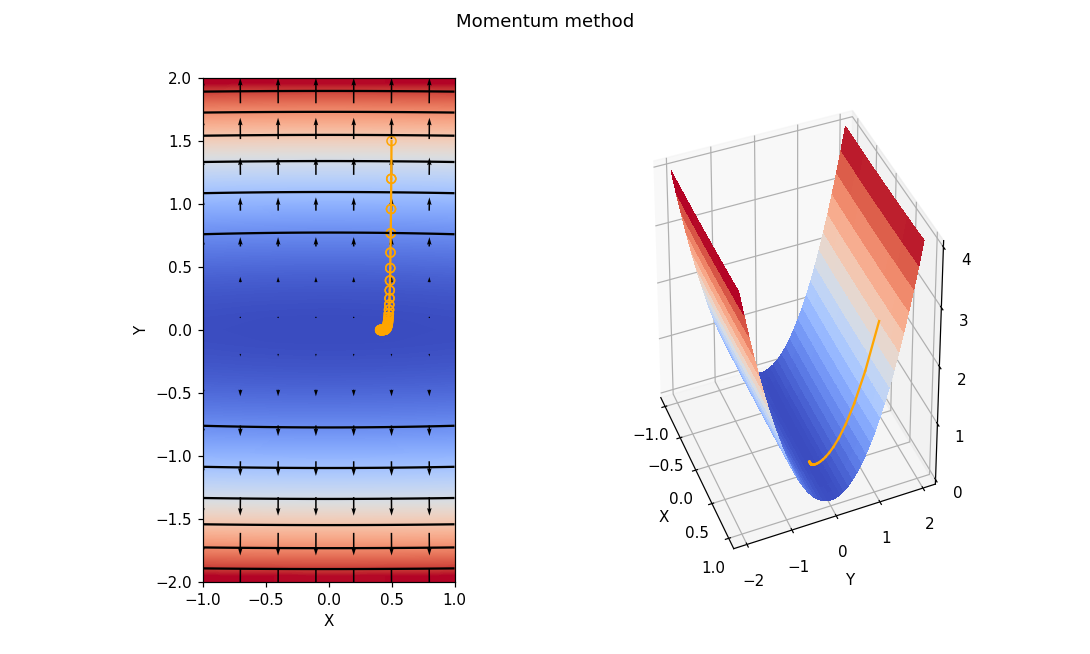

In [8]:
def momentum(x_start, step, g, discount=0.7, convergence_threshold=1E-6, max_iter=50, debug=False):
    x = np.array(x_start, dtype='float64')
    trajectory = [[x[0], x[1], f(x)]]
    pre_grad = np.zeros_like(x)
    for i in range(max_iter):
        grad = g(x)
        pre_grad = pre_grad * discount + grad
        x -= pre_grad * step
        trajectory.append([x[0], x[1], f(x)])
        if debug:
            print('[ Epoch {0} ] x = {1}, grad = {2}, f = {3}'.format(i, x, grad, f(x)))
        if abs(sum(grad)) < convergence_threshold:
            print("Converged in " + str(i+1) + " iterations")
            break
    return x, trajectory

res, trajectory = gd(initial_point, .1, g, convergence_threshold=convergence_threshold, max_iter=max_iter)
plot_cost_func(X, Y, Z, trajectory, Z_grad=Z_grad, title="Momentum method")

Nesterov method
===============

<IPython.core.display.Javascript object>


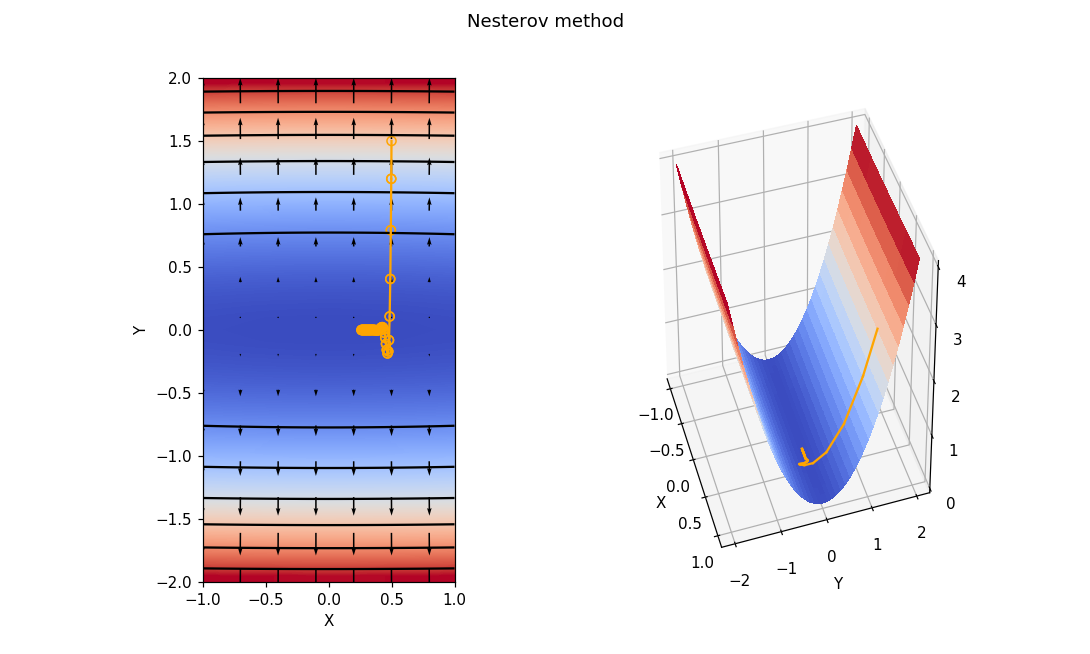

In [9]:
def nesterov(x_start, step, g, discount=0.7, convergence_threshold=1E-6, max_iter=50, debug=False):
    x = np.array(x_start, dtype='float64')
    trajectory = [[x[0], x[1], f(x)]]
    pre_grad = np.zeros_like(x)
    for i in range(max_iter):
        x_future = x - step * discount * pre_grad
        grad = g(x_future)
        pre_grad = pre_grad * 0.7 + grad 
        x -= pre_grad * step
        trajectory.append([x[0], x[1], f(x)])
        if debug:
            print('[ Epoch {0} ] x = {1}, grad = {2}, f = {3}'.format(i, x, grad, f(x)))
        if abs(sum(grad)) < convergence_threshold:
            print("Converged in " + str(i+1) + " iterations")
            break
    return x, trajectory

res, trajectory = nesterov(initial_point, 0.1, g, convergence_threshold=convergence_threshold, max_iter=max_iter)
plot_cost_func(X, Y, Z, trajectory, Z_grad=Z_grad, title="Nesterov method")

<IPython.core.display.Javascript object>


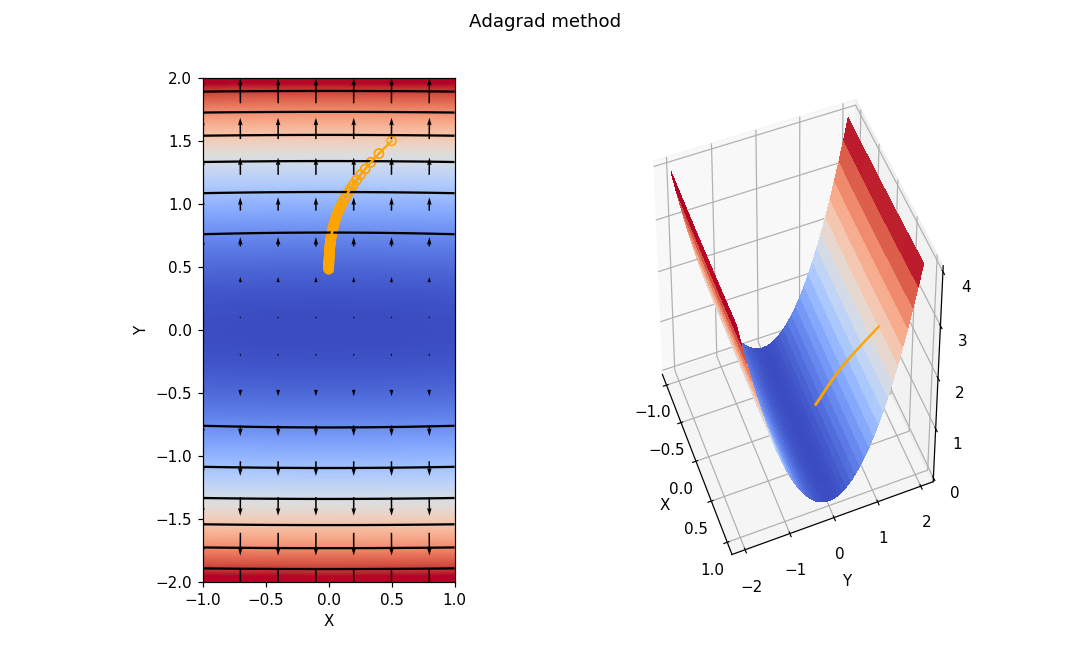

In [10]:
def adagrad(x_start, g, eta=.1, convergence_threshold=1E-6, fudge_factor=1E-7, max_iter=50, debug=False):
    G = fudge_factor * np.ones_like(x_start)
    x = np.array(x_start, dtype='float64')
    trajectory = [[x[0], x[1], f(x)]]
    for i in range(max_iter):
        grad = g(x)
        G += grad**2
        x -= eta * grad / np.sqrt(G)
        trajectory.append([x[0], x[1], f(x)])
        if debug:
            print('[ Epoch {0} ] x = {1}, grad = {2}, f = {3}'.format(i, x, grad, f(x)))
        if np.abs(np.sum(grad)) < convergence_threshold:
            print("Converged in " + str(i+1) + " iterations")
            break
    return x, trajectory

res, trajectory = adagrad(initial_point, g, convergence_threshold=convergence_threshold, max_iter=max_iter)
plot_cost_func(X, Y, Z, trajectory, Z_grad=Z_grad, title="Adagrad method")

<IPython.core.display.Javascript object>


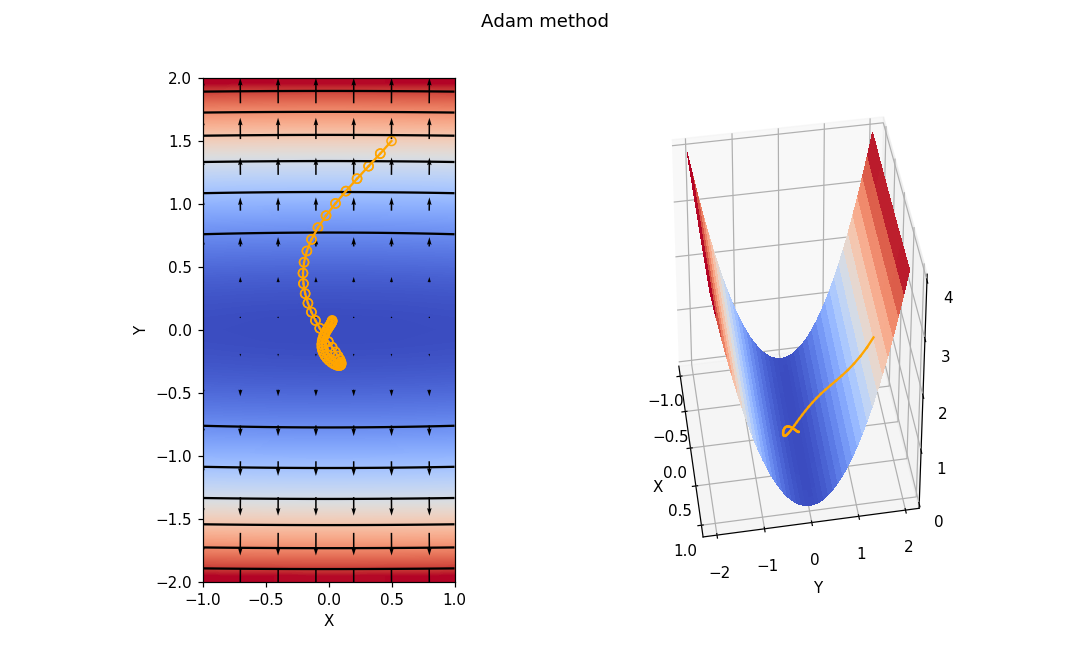

In [11]:
def adam(x_start, g, eta=.1, beta1=.9, beta2=.999, convergence_threshold=1E-6, fudge_factor=1E-7, max_iter=50, debug=False):
    """Adaptive Moment Estimation (Adam)
    
    ``m`` is an estimate of the first moment (mean) of the gradient
    ``v`` is an estimate of the second moment (uncentered variance) of the gradient
    
    The "hatted" versions are bias-corrected versions because initialisation to 0 imposes a bias towards 0.
    """
    m = np.zeros_like(x_start)
    v = m + fudge_factor
    x = x_start.copy()
    trajectory = [[x[0], x[1], f(x)]]
    for i in range(max_iter):
        grad = g(x)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        mhat = m / (1 - beta1**(i+1))
        vhat = v / (1 - beta2**(i+1))
        x -= eta * mhat / (np.sqrt(vhat) + fudge_factor)
        trajectory.append([x[0], x[1], f(x)])
        if debug:
            print('[ Epoch {0} ] x = {1}, grad = {2}, f = {3}'.format(i, x, grad, f(x)))
        if np.abs(np.sum(grad)) < convergence_threshold:
            print("Converged in " + str(i+1) + " iterations")
            break
    return x, trajectory

res, trajectory = adam(initial_point, g, eta=.1, convergence_threshold=convergence_threshold, max_iter=max_iter)
plot_cost_func(X, Y, Z, trajectory, Z_grad=Z_grad, title="Adam method")

References
==========

1. <a id="cite_ruder_blog"></a> "An overview of gradient descent optimization algorithms", Sebasian Ruder, URL: <a href="http://ruder.io/optimizing-gradient-descent/">http://ruder.io/optimizing-gradient-descent/</a> (retrieved Nov 19th, 2017)
2. <a id="cite_ruder_paper"></a> Sebastian Ruder (2016). An overview of gradient descent optimisation algorithms. arXiv preprint <a href="https://arxiv.org/abs/1609.04747">arXiv:1609.04747</a>